 TRY
top_k_categorical_accuracy
https://stackoverflow.com/questions/47887533/keras-convolution-along-samples
https://keras.io/layers/wrappers/#timedistributed

In [1]:
sequence_size = 10
input_width = 160
input_height = 100
channels = 2
class_number = 12
data_path = "D:\\Python\\Wormax_learn2\\preprocessed_data_local_notshuffled_2ch\\"

In [2]:
from keras.models import Sequential, Model
from keras import layers, Input
import keras.backend as K

def actual_acc(y_true, y_pred):
    return K.equal(K.argmax(y_pred), K.argmax(y_true))
        
def convolution_feature_extractor(input_height, input_width, channels):
    input_tensor = Input(shape=(input_height, input_width, channels))
    
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    #x = layers.Dropout(0.5)(x)
    output_tensor = layers.Dense(512, activation='relu')(x)
    
    model = Model(input_tensor, output_tensor)    
    model.summary()
    return model

def define_model():
    input_tensor = Input(shape=(sequence_size, input_height, input_width, channels))
        
    x = layers.TimeDistributed(
            convolution_feature_extractor(input_height, input_width, channels))(input_tensor)
    x = layers.GRU(32,
    #        dropout=0.1,
    #        recurrent_dropout=0.5,
            return_sequences=True
                  )(x)
    x = layers.GRU(64, activation='relu',
    #        dropout=0.1,
    #        recurrent_dropout=0.5
                  )(x)
    
    output_tensor = layers.Dense(class_number, activation='softmax')(x)
    model = Model(input_tensor, output_tensor)
   
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                  metrics=[actual_acc])
    
    model.summary()
    return model

Q:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
model = define_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 160, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 158, 32)       608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 18, 128)       0         
__________

In [4]:
# little prepocessing
from math import atan2, pi

def get_angle(x, y):
    return atan2(y, x)

def get_direction(x, y, n_classes = 12):
    return round(get_angle(x, y)/2/pi*n_classes)%n_classes

In [5]:
import numpy as np
import os
import random
from functools import reduce
from keras.utils import to_categorical

# Training and validation
data_ratio = 0.7

# Generator done for not to overflow MEM
# holds one data file for every instance(train and validation)
def generator(data_dir, sequence_size, num_classes, role, batch_size=128):
    
    listdir = []
    listdir = filter(lambda x: os.path.isfile, os.listdir(data_dir))
    listdir = np.array(list(listdir))
    random.shuffle(listdir)
    
    #print('Found {} files for {}'.format(len(listdir), role))
    
    file_i = 0
    while 1:
        data = np.load(data_dir + listdir[file_i])
        file_i = (file_i+1) if file_i+1<len(listdir) else 0
        
        if role == 'train':
            data = data[:int(round(len(data)*data_ratio))]
        elif role == 'validation':
            data = data[int(round(len(data)*data_ratio)):]
        else:
            raise 'bad role parameter'
            
        i = 0
        while i + batch_size + sequence_size + 1 < len(data):
            samples = np.zeros((batch_size, sequence_size, input_height, input_width, channels))
            targets = np.zeros((batch_size, num_classes))
            for j in range(batch_size):
                # some issue with shapes(dummy reshape)
                sample = np.zeros((sequence_size, input_height, input_width, channels))
                for k, dt in enumerate(data[i + j:i + j + sequence_size, 0]):
                    sample[k] = dt
                samples[j] = sample
                targets[j] = to_categorical(get_direction(*data[i + j + sequence_size][1][:2]), num_classes=num_classes)
            i += batch_size
            yield samples, targets

In [6]:
import numpy as np

train_generator = generator(data_path, sequence_size, class_number, 'train', batch_size=10)
validation_generator = generator(data_path, sequence_size, class_number, 'validation', batch_size=10)

print(next(train_generator)[0].shape)

(10, 10, 100, 160, 2)


In [10]:
model.evaluate_generator(validation_generator, 1000)

[2.581914981007576, 0.1303000006750226]

In [6]:
steps_per_epoch = 100
history = model.fit_generator(train_generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=1000,
                            validation_data=validation_generator,
                            validation_steps=int(round(steps_per_epoch/data_ratio*(1-data_ratio))),
                            shuffle=True
                             )

model.save('worm1.h5')


(10, 10, 100, 160, 2)
Epoch 1/1000
100/100 [==============================] - 23s 229ms/step - loss: 2.4109 - actual_acc: 0.2180 - val_loss: 2.2076 - val_actual_acc: 0.4326
Epoch 2/1000
100/100 [==============================] - 18s 180ms/step - loss: 2.4097 - actual_acc: 0.1460 - val_loss: 2.4065 - val_actual_acc: 0.1698
Epoch 3/1000
100/100 [==============================] - 18s 179ms/step - loss: 2.4483 - actual_acc: 0.1200 - val_loss: 2.4551 - val_actual_acc: 0.2349
Epoch 4/1000
100/100 [==============================] - 18s 180ms/step - loss: 2.4129 - actual_acc: 0.2070 - val_loss: 2.4602 - val_actual_acc: 0.1721
Epoch 5/1000
100/100 [==============================] - 18s 179ms/step - loss: 2.4701 - actual_acc: 0.1120 - val_loss: 2.3319 - val_actual_acc: 0.0605
Epoch 6/1000
100/100 [==============================] - 21s 212ms/step - loss: 2.3588 - actual_acc: 0.1720 - val_loss: 2.5122 - val_actual_acc: 0.0744
Epoch 7/1000
100/100 [==============================] - 23s 225ms/step -

Epoch 55/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.4121 - actual_acc: 0.1620 - val_loss: 2.3865 - val_actual_acc: 0.1023
Epoch 56/1000
100/100 [==============================] - 23s 234ms/step - loss: 2.4590 - actual_acc: 0.1280 - val_loss: 2.2438 - val_actual_acc: 0.2767
Epoch 57/1000
100/100 [==============================] - 24s 236ms/step - loss: 2.3577 - actual_acc: 0.1670 - val_loss: 2.3028 - val_actual_acc: 0.2093
Epoch 58/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.3281 - actual_acc: 0.1150 - val_loss: 2.5203 - val_actual_acc: 0.0953
Epoch 59/1000
100/100 [==============================] - 18s 181ms/step - loss: 2.4748 - actual_acc: 0.1300 - val_loss: 2.3144 - val_actual_acc: 0.1698
Epoch 60/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.2500 - actual_acc: 0.2260 - val_loss: 2.4833 - val_actual_acc: 0.1140
Epoch 61/1000
100/100 [==============================] - 18s 181ms/step - loss: 2.3264 -

Epoch 109/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.3900 - actual_acc: 0.1750 - val_loss: 2.4350 - val_actual_acc: 0.0860
Epoch 110/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.4099 - actual_acc: 0.1280 - val_loss: 2.5985 - val_actual_acc: 0.0814
Epoch 111/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.2574 - actual_acc: 0.2340 - val_loss: 2.3484 - val_actual_acc: 0.1558
Epoch 112/1000
100/100 [==============================] - 23s 228ms/step - loss: 2.3971 - actual_acc: 0.0930 - val_loss: 2.4124 - val_actual_acc: 0.2070
Epoch 113/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.5422 - actual_acc: 0.0240 - val_loss: 2.5220 - val_actual_acc: 0.0372
Epoch 114/1000
100/100 [==============================] - 23s 228ms/step - loss: 2.4580 - actual_acc: 0.1660 - val_loss: 2.3439 - val_actual_acc: 0.2419
Epoch 115/1000
100/100 [==============================] - 18s 182ms/step - loss: 2

100/100 [==============================] - 25s 245ms/step - loss: 2.3770 - actual_acc: 0.1850 - val_loss: 2.6687 - val_actual_acc: 0.0140
Epoch 216/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.4573 - actual_acc: 0.1550 - val_loss: 2.3618 - val_actual_acc: 0.1349
Epoch 217/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.4280 - actual_acc: 0.0890 - val_loss: 2.2915 - val_actual_acc: 0.1070
Epoch 218/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.3820 - actual_acc: 0.1590 - val_loss: 2.5310 - val_actual_acc: 0.1326
Epoch 219/1000
100/100 [==============================] - 25s 248ms/step - loss: 2.4808 - actual_acc: 0.0610 - val_loss: 2.5411 - val_actual_acc: 0.1023
Epoch 220/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.3345 - actual_acc: 0.1750 - val_loss: 2.1507 - val_actual_acc: 0.2884
Epoch 221/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.4198 - actual_

Q:\Program Files\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185918). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 23s 230ms/step - loss: 2.4164 - actual_acc: 0.1140 - val_loss: 2.3478 - val_actual_acc: 0.1302
Epoch 258/1000
100/100 [==============================] - 18s 185ms/step - loss: 2.4712 - actual_acc: 0.1110 - val_loss: 2.4099 - val_actual_acc: 0.1395
Epoch 259/1000
100/100 [==============================] - 26s 258ms/step - loss: 2.3764 - actual_acc: 0.1190 - val_loss: 2.5607 - val_actual_acc: 0.1488
Epoch 260/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.3569 - actual_acc: 0.1660 - val_loss: 2.3683 - val_actual_acc: 0.1349
Epoch 261/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.4308 - actual_acc: 0.1320 - val_loss: 2.4740 - val_actual_acc: 0.1651
Epoch 262/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.4680 - actual_acc: 0.1410 - val_loss: 2.4096 - val_actual_acc: 0.1791
Epoch 263/1000
100/100 [==============================] - 24s 236ms/step - loss: 2.4240 - actual_

100/100 [==============================] - 18s 183ms/step - loss: 2.4244 - actual_acc: 0.1220 - val_loss: 2.4331 - val_actual_acc: 0.1628
Epoch 364/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.4141 - actual_acc: 0.0860 - val_loss: 2.4178 - val_actual_acc: 0.1395
Epoch 365/1000
100/100 [==============================] - 18s 184ms/step - loss: 2.3214 - actual_acc: 0.1530 - val_loss: 2.5587 - val_actual_acc: 0.0186
Epoch 366/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.3543 - actual_acc: 0.1850 - val_loss: 2.4043 - val_actual_acc: 0.1884
Epoch 367/1000
100/100 [==============================] - 25s 252ms/step - loss: 2.3493 - actual_acc: 0.1870 - val_loss: 2.2054 - val_actual_acc: 0.2907
Epoch 368/1000
100/100 [==============================] - 23s 232ms/step - loss: 2.3882 - actual_acc: 0.1330 - val_loss: 2.4872 - val_actual_acc: 0.1163
Epoch 369/1000
100/100 [==============================] - 18s 184ms/step - loss: 2.4402 - actual_

100/100 [==============================] - 18s 184ms/step - loss: 2.3848 - actual_acc: 0.1510 - val_loss: 2.5785 - val_actual_acc: 0.0814
Epoch 470/1000
100/100 [==============================] - 18s 184ms/step - loss: 2.3714 - actual_acc: 0.1990 - val_loss: 2.4036 - val_actual_acc: 0.1907
Epoch 471/1000
100/100 [==============================] - 18s 184ms/step - loss: 2.4070 - actual_acc: 0.0970 - val_loss: 2.5085 - val_actual_acc: 0.1419
Epoch 472/1000
100/100 [==============================] - 26s 260ms/step - loss: 2.4810 - actual_acc: 0.0570 - val_loss: 2.2469 - val_actual_acc: 0.1674
Epoch 473/1000
100/100 [==============================] - 24s 245ms/step - loss: 2.4780 - actual_acc: 0.0870 - val_loss: 2.3724 - val_actual_acc: 0.1837
Epoch 474/1000
100/100 [==============================] - 18s 184ms/step - loss: 2.4020 - actual_acc: 0.1720 - val_loss: 2.5508 - val_actual_acc: 0.1721
Epoch 475/1000
100/100 [==============================] - 18s 184ms/step - loss: 2.3790 - actual_

100/100 [==============================] - 24s 242ms/step - loss: 2.4134 - actual_acc: 0.2030 - val_loss: 2.4388 - val_actual_acc: 0.1116
Epoch 576/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.2533 - actual_acc: 0.2920 - val_loss: 2.4442 - val_actual_acc: 0.1186
Epoch 577/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.5112 - actual_acc: 0.1270 - val_loss: 2.7046 - val_actual_acc: 0.0326
Epoch 578/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.5084 - actual_acc: 0.0990 - val_loss: 2.4538 - val_actual_acc: 0.0977
Epoch 579/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.3913 - actual_acc: 0.1080 - val_loss: 2.2510 - val_actual_acc: 0.1698
Epoch 580/1000
100/100 [==============================] - 25s 251ms/step - loss: 2.5787 - actual_acc: 0.1310 - val_loss: 2.4186 - val_actual_acc: 0.2047
Epoch 581/1000
100/100 [==============================] - 18s 184ms/step - loss: 2.4671 - actual_

100/100 [==============================] - 19s 185ms/step - loss: 2.4804 - actual_acc: 0.1260 - val_loss: 2.7127 - val_actual_acc: 0.0256
Epoch 682/1000
100/100 [==============================] - 25s 252ms/step - loss: 2.4639 - actual_acc: 0.1930 - val_loss: 2.5323 - val_actual_acc: 0.0744
Epoch 683/1000
100/100 [==============================] - 18s 183ms/step - loss: 2.4705 - actual_acc: 0.0240 - val_loss: 2.3741 - val_actual_acc: 0.1814
Epoch 684/1000
100/100 [==============================] - 19s 186ms/step - loss: 2.3569 - actual_acc: 0.1040 - val_loss: 2.4905 - val_actual_acc: 0.0419
Epoch 685/1000
100/100 [==============================] - 19s 185ms/step - loss: 2.3347 - actual_acc: 0.2860 - val_loss: 2.4653 - val_actual_acc: 0.1209
Epoch 686/1000
100/100 [==============================] - 18s 185ms/step - loss: 2.4900 - actual_acc: 0.1020 - val_loss: 2.4298 - val_actual_acc: 0.1535
Epoch 687/1000
100/100 [==============================] - 23s 232ms/step - loss: 2.4065 - actual_

100/100 [==============================] - 18s 183ms/step - loss: 2.4338 - actual_acc: 0.1520 - val_loss: 2.2751 - val_actual_acc: 0.2163
Epoch 788/1000
100/100 [==============================] - 25s 252ms/step - loss: 2.5478 - actual_acc: 0.0920 - val_loss: 2.3710 - val_actual_acc: 0.0674
Epoch 789/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.4219 - actual_acc: 0.1750 - val_loss: 2.4793 - val_actual_acc: 0.0744
Epoch 790/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.3885 - actual_acc: 0.1510 - val_loss: 2.3880 - val_actual_acc: 0.1674
Epoch 791/1000
100/100 [==============================] - 18s 182ms/step - loss: 2.4387 - actual_acc: 0.1000 - val_loss: 2.6096 - val_actual_acc: 0.0163
Epoch 792/1000
100/100 [==============================] - 24s 235ms/step - loss: 2.3648 - actual_acc: 0.1200 - val_loss: 2.4836 - val_actual_acc: 0.1163
Epoch 793/1000
100/100 [==============================] - 24s 244ms/step - loss: 2.4370 - actual_

100/100 [==============================] - 18s 181ms/step - loss: 2.5501 - actual_acc: 0.1080 - val_loss: 2.3661 - val_actual_acc: 0.1070
Epoch 894/1000
100/100 [==============================] - 25s 251ms/step - loss: 2.4471 - actual_acc: 0.1690 - val_loss: 2.4994 - val_actual_acc: 0.2093
Epoch 895/1000
100/100 [==============================] - 26s 263ms/step - loss: 2.4276 - actual_acc: 0.1520 - val_loss: 2.5384 - val_actual_acc: 0.1302
Epoch 896/1000
100/100 [==============================] - 18s 181ms/step - loss: 2.4910 - actual_acc: 0.0920 - val_loss: 2.3481 - val_actual_acc: 0.2907
Epoch 897/1000
100/100 [==============================] - 18s 181ms/step - loss: 2.5370 - actual_acc: 0.1150 - val_loss: 2.2654 - val_actual_acc: 0.1349
Epoch 898/1000
100/100 [==============================] - 18s 181ms/step - loss: 2.4502 - actual_acc: 0.1280 - val_loss: 2.2680 - val_actual_acc: 0.3163
Epoch 899/1000
100/100 [==============================] - 18s 181ms/step - loss: 2.4546 - actual_

100/100 [==============================] - 25s 253ms/step - loss: 2.4165 - actual_acc: 0.0880 - val_loss: 2.2234 - val_actual_acc: 0.2186
Epoch 1000/1000
100/100 [==============================] - 18s 181ms/step - loss: 2.3922 - actual_acc: 0.1600 - val_loss: 2.4232 - val_actual_acc: 0.1326


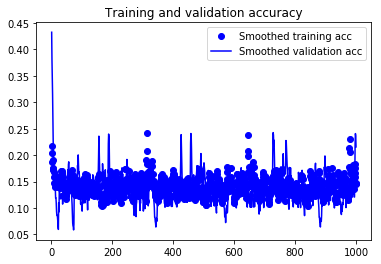

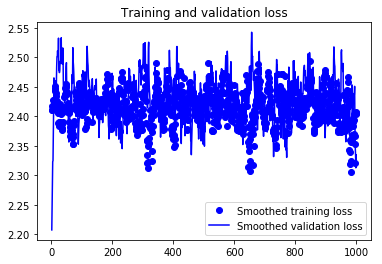

In [12]:
import matplotlib.pyplot as plt

acc = history.history['actual_acc']
val_acc = history.history['val_actual_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()